
# 2D ERT modeling and inversion


In [37]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

## Geometry definition
Create geometry definition for the modelling domain. ``worldMarker=True``
indicates the default boundary conditions for the ERT



(<Axes: >, None)

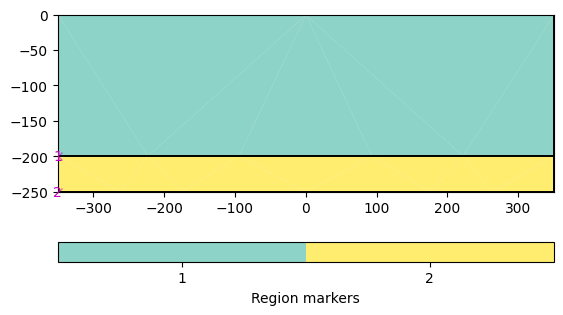

In [38]:
world = mt.createWorld(start=[-350, 0], end=[350, -250], layers=[-200],
                       worldMarker=True)
pg.show(world)

Calculate fault points position


In [39]:
x1 = -125
y1 = -200
y2 = -250
x2 = x1 - np.tan(np.radians(-30)) * (y2 - y1) #Dip 60°

Create fault

In [40]:
fault = mt.createPolygon([[x1, y1], [x2, y2]], isClosed=True, marker=2)
geom = world + fault

Optional: show the geometry

(<Axes: >, None)

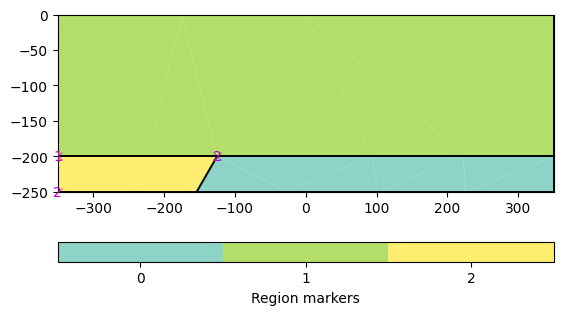

In [41]:
pg.show(geom)

## Synthetic data generation
Create a Dipole Dipole ('dd') measuring scheme with 21 electrodes.



In [ ]:
scheme = ert.createData(elecs=np.linspace(start=-15, stop=15, num=21),
                           schemeName='dd')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



In [ ]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 100.],
          [2, 75.],
          [3, 50.],
          [4, 150.],
          [5, 25]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [ ]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



In [ ]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('simple.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [ ]:
mgr = ert.ERTManager('simple.dat')

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



In [ ]:
inv = mgr.invert(lam=20, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



In [ ]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

You can also provide your own mesh (e.g., a structured grid if you like them)
Note, that x and y coordinates needs to be in ascending order to ensure that
all the cells in the grid have the correct orientation, i.e., all cells need
to be numbered counter-clockwise and the boundary normal directions need to
point outside.



In [ ]:
inversionDomain = pg.createGrid(x=np.linspace(start=-18, stop=18, num=33),
                                y=-pg.cat([0], pg.utils.grange(0.5, 8, n=5))[::-1],
                                marker=2)

## Inversion with custom mesh
The inversion domain for ERT problems needs a boundary that represents the
far regions in the subsurface of the halfspace.
Give a cell marker lower than the marker for the inversion region, the lowest
cell marker in the mesh will be the inversion boundary region by default.



In [ ]:
grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
                                           xbound=50, ybound=50)
pg.show(grid, markers=True)

The Inversion can be called with data and mesh as argument as well



In [ ]:
model = mgr.invert(data, mesh=grid, lam=20, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 1.4, significant=2)

## Visualization
You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.



In [ ]:
modelPD = mgr.paraModel(model)  # do the mapping
pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r',
        logScale=True, cMin=25, cMax=150)

pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
mgr.showResult(ax=ax3, cMin=25, cMax=150, orientation="vertical")

labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
for ax, label in zip([ax1, ax2, ax3], labels):
    ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
    ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
    ax.set_title(label)